Starting...


100%|████████████████████████████████████████| 421/421 [00:03<00:00, 80.21it/s]


[0.1595251117814692, 0.15626892007036297, 0.14909386199623711, 0.13579693701246887]
[0.30866666666666664, 0.47783333333333333, 0.527, 0.6078333333333333, 0.5883333333333334, 0.6695, 0.7176666666666667, 0.723, 0.7411666666666666, 0.7723333333333333]


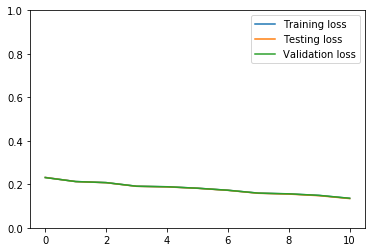

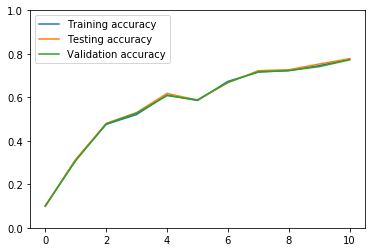

In [109]:
import numpy as np
import matplotlib.pyplot as plt
import mnist
import tqdm

#mnist.init()
def should_early_stop(validation_loss, num_steps=7):
    if len(validation_loss) < num_steps+1:
        return False

    is_increasing = [validation_loss[i] <= validation_loss[i+1] for i in range(-num_steps-1, -1)]
    return sum(is_increasing) == len(is_increasing)

def train_val_split(X, Y, val_percentage):
  """
    Selects samples from the dataset randomly to be in the validation set. Also, shuffles the train set.
    --
    X: [N, num_features] numpy vector,
    Y: [N, 1] numpy vector
    val_percentage: amount of data to put in validation set
  """
  dataset_size = X.shape[0]
  idx = np.arange(0, dataset_size)
  np.random.shuffle(idx)

  train_size = int(dataset_size*(1-val_percentage))
  idx_train = idx[:train_size]
  idx_val = idx[train_size:]
  X_train, Y_train = X[idx_train], Y[idx_train]
  X_val, Y_val = X[idx_val], Y[idx_val]
  return X_train, Y_train, X_val, Y_val
v_ji=0
def onehot_encode(Y, n_classes=10):
    onehot = np.zeros((Y.shape[0], n_classes))
    onehot[np.arange(0, Y.shape[0]), Y] = 1
    return onehot

def bias_trick(X):
    return np.concatenate((X, np.ones((len(X), 1))), axis=1)

def check_gradient_hidden(X, targets, w_ji, w_kj, epsilon, computed_gradient):
    print("Checking gradient...")
    dw = np.zeros_like(w_ji)
    for k in range(w_ji.shape[0]):
        for j in range(w_ji.shape[1]):
            new_weight1, new_weight2 = np.copy(w_ji), np.copy(w_ji)
            new_weight1[k,j] += epsilon
            new_weight2[k,j] -= epsilon
            [_,output1] = feedforward(X, new_weight1, w_kj)
            [_,output2] = feedforward(X, new_weight2, w_kj)
            loss1 = cross_entropy_loss(output1, targets)
            loss2 = cross_entropy_loss(output2, targets)
            dw[k,j] = (loss1 - loss2) / (2*epsilon)
    maximum_aboslute_difference = abs(computed_gradient-dw).max()
    if (maximum_aboslute_difference > epsilon**2):
        print(computed_gradient-dw)
    assert maximum_aboslute_difference <= epsilon**2, "Absolute error was: {}".format(maximum_aboslute_difference)

def check_gradient_output(X, targets, w_kj, epsilon, computed_gradient):
    print("Checking gradient...")
    dw = np.zeros_like(w_kj)
    for k in range(w_kj.shape[0]):
        for j in range(w_kj.shape[1]):
            new_weight1, new_weight2 = np.copy(w_kj), np.copy(w_kj)
            new_weight1[k,j] += epsilon
            new_weight2[k,j] -= epsilon
            output1 = forward_softmax(X, new_weight1)
            output2 = forward_softmax(X, new_weight2)
            loss1 = cross_entropy_loss(output1, targets)
            loss2 = cross_entropy_loss(output2, targets)
            dw[k,j] = (loss1 - loss2) / (2*epsilon)
    maximum_aboslute_difference = abs(computed_gradient-dw).max()
    if (maximum_aboslute_difference > epsilon**2):
        print(computed_gradient-dw)
    assert maximum_aboslute_difference <= epsilon**2, "Absolute error was: {}".format(maximum_aboslute_difference)

def softmax(a):
    a_exp = np.exp(a)
    return a_exp / a_exp.sum(axis=1, keepdims=True)

def forward_sigmoid_improved(X, w_ji):
    a = np.dot(X,w_ji.T)
    return 1.7159*np.tanh(2*a/3)

def forward_sigmoid(X, w_ji):
    return 1/(1+np.exp(-np.dot(X,w_ji.T)))

def ReLU(X,w):
    return np.where(np.dot(X,w.T) > 0, np.dot(X,w.T),0)

def dReLU(X,w):
    dx = np.ones_like(np.dot(X,w.T))
    dx[np.dot(X,w.T) < 0] = 0
    return dx

def leakyReLU(X,w):
    return np.where(np.dot(X,w.T) > 0, np.dot(X,w.T), 0.01*np.dot(X,w.T))
    
def dleakyReLU(X,w, alpha =0.01):
    #return np.where(np.dot(X,w.T) > 0, 1., 0.01)
    dx = np.ones_like(np.dot(X,w.T))
    dx[np.dot(X,w.T) < 0] = alpha
    return dx
def ELU(X,w, alpha = 0.005):
    return np.where(np.dot(X,w.T) > 0, np.dot(X,w.T), alpha*(np.exp(np.dot(X,w.T))-1))

def dELU(X,w, alpha =0.005):
    #return np.where(np.dot(X,w.T) > 0, 1., alpha*np.exp(np.dot(X,w.T)))
    dx = np.ones_like(np.dot(X,w.T))
    dx[np.dot(X,w.T) < 0] = alpha*np.exp(np.dot(X,w.T))
    return dx
def forward_softmax(X, w_kj):
    a = X.dot(w_kj.T)
    return softmax(a)

def feedforward_improved(X, w_ji, w_kj):
    a_j = ELU(X,w_ji)
    output = forward_softmax(a_j, w_kj)
    return a_j, output

def feedforward(X, w_ji, w_kj):
    a_j = forward_sigmoid(X,w_ji)
    output = forward_softmax(a_j, w_kj)
    return a_j, output

def calculate_accuracy(output, targets):
    predictions = output.argmax(axis=1)
    targets = targets.argmax(axis=1)
    return (predictions == targets).mean()

def cross_entropy_loss(output, targets):
    assert output.shape == targets.shape
    log_y = np.log(output)
    cross_entropy = -targets * log_y
    return cross_entropy.mean() #equivalent to summing and dividing by batch_size * num_classes

def bit_shift_image_UP(X_for_augment):
    for img_num in range(X_for_augment.shape[0]):
        for j in range(HEIGHT):
            for i in range(WIDTH):
                if(j+num_bits_shifted<HEIGHT):
                    X_for_augment[img_num][j][i] = X_for_augment[img_num][j+num_bits_shifted][i]
                else:
                    X_for_augment[img_num][j][i] = -1.
    return X_for_augment

def bit_shift_image_DOWN(X_for_augment):
    for img_num in range(X_for_augment.shape[0]):
        for j in range(HEIGHT):
            for i in range(WIDTH):
                if(HEIGHT-(j+num_bits_shifted)>0):
                    X_for_augment[img_num][HEIGHT-1-j][i] = X_for_augment[img_num][HEIGHT-1-(j+num_bits_shifted)][i]
                else:
                    X_for_augment[img_num][HEIGHT-1-j][i] = -1.        
    return X_for_augment

def bit_shift_image_LEFT(X_for_augment):
    for img_num in range(X_for_augment.shape[0]):
        for j in range(HEIGHT):
            for i in range(WIDTH):
                if(i+num_bits_shifted<WIDTH):
                    X_for_augment[img_num][j][i] = X_for_augment[img_num][j][i+num_bits_shifted]
                else:
                    X_for_augment[img_num][j][i] = -1.        
    return X_for_augment

def bit_shift_image_RIGHT(X_for_augment):
    for img_num in range(X_for_augment.shape[0]):
        for j in range(HEIGHT):
            for i in range(WIDTH):
                if(WIDTH-(i+num_bits_shifted)>0):
                    X_for_augment[img_num][j][WIDTH-1-i] = X_for_augment[img_num][j][WIDTH-1-(i+num_bits_shifted)]
                else:
                    X_for_augment[img_num][j][WIDTH-1-i] = -1.        
    return X_for_augment

def bit_shift_direction(X,random, direction):
    X= X[:,:-1] # Remove bias
    X = X.reshape(X.shape[0],28, 28)
    if(random):
        direction = np.random.randint(4)
    if(direction==0):
        X=bit_shift_image_UP(X)
    elif(direction==1):
        X=bit_shift_image_DOWN(X)
    elif(direction==2):
        X=bit_shift_image_LEFT(X)
    elif(direction==3):
        X=bit_shift_image_RIGHT(X)
        
    X = X.reshape(X.shape[0],28*28)
    X = bias_trick(X)
    return X


def gradient_descent_softmax(A, targets, w_ji, w_kj, learning_rate, should_check_gradient):
    normalization_factor = A.shape[0] * targets.shape[1] # batch_size * num_classes
    outputs = forward_softmax(A, w_kj)
    delta_k = - (targets - outputs)

    dw = delta_k.T.dot(A)
    dw = dw / normalization_factor # Normalize gradient equally as loss normalization
    assert dw.shape == w_kj.shape, "dw shape was: {}. Expected: {}".format(dw.shape, w.shape)

    if should_check_gradient:
        check_gradient_output(A, targets, w_kj, 1e-2,  dw)

    w_kj = w_kj - learning_rate * dw
    return w_kj

def gradient_descent_softmax_nesterov_momentum(A, targets, w_ji, w_kj, learning_rate, should_check_gradient):
    normalization_factor = A.shape[0] * targets.shape[1] # batch_size * num_classes
    global v_2
    v_kj = v_2
    approximated_future_w_kj = w_kj + mu*v_kj
    outputs = forward_softmax(A, approximated_future_w_kj)
    delta_k = - (targets - outputs)

    dw = delta_k.T.dot(A)
    dw = dw / normalization_factor # Normalize gradient equally as loss normalization
    assert dw.shape == approximated_future_w_kj.shape, "dw shape was: {}. Expected: {}".format(dw.shape, w.shape)

    if should_check_gradient:
        check_gradient_output(A, targets, w_kj, 1e-2,  dw)
    v_kj = mu*v_kj - learning_rate * dw
    w_kj = w_kj +v_kj
    v_2=v_kj
    return w_kj
def gradient_descent_sigmoid_improved_nesterov_momentum(X, a_j, targets, w_ji, w_kj, learning_rate, should_check_gradient):
    global v_1
    v_ji = v_1
    v_kj = v_2
    normalization_factor = X.shape[0] * targets.shape[1] # batch_size * num_classes
    approximated_future_w_ji = w_ji + mu*v_ji
    approximated_future_w_kj = w_kj + mu*v_kj
    [a_j, outputs] = feedforward_improved(X, approximated_future_w_ji, approximated_future_w_kj)
    d_sigmoid = 1.7159*2/3*(1 - np.tanh(2*np.dot(X,approximated_future_w_ji.T)/3)**2).T
    delta_k = -(targets - outputs)
    delta_j = d_sigmoid*np.dot(approximated_future_w_kj.T,delta_k.T)

    dw = delta_j.dot(X)
    dw = dw / normalization_factor # Normalize gradient equally as loss normalization
    assert dw.shape == approximated_future_w_ji.shape, "dw shape was: {}. Expected: {}".format(dw.shape, w1.shape)

    if should_check_gradient:
        check_gradient_hidden(X, targets, approximated_future_w_ji, approximated_future_w_kj, 1e-2,  dw)
    v_ji = mu*v_ji - learning_rate * dw
    w_ji = w_ji +v_ji
    v_1 = v_ji
    return w_ji

def gradient_descent_sigmoid_improved(X, a_j, targets, w_ji, w_kj, learning_rate, should_check_gradient):
    normalization_factor = X.shape[0] * targets.shape[1] # batch_size * num_classes
    [a_j, outputs] = feedforward_improved(X, w_ji, w_kj)
    #d_sigmoid = 1.7159*2/3*(1 - np.tanh(2*np.dot(X,w_ji.T)/3)**2).T
    d_ELU = ELU(X,w_ji)
    delta_k = -(targets - outputs)
    delta_j = d_ELU.T*np.dot(w_kj.T,delta_k.T)

    dw = delta_j.dot(X)
    dw = dw / normalization_factor # Normalize gradient equally as loss normalization
    assert dw.shape == w_ji.shape, "dw shape was: {}. Expected: {}".format(dw.shape, w1.shape)

    if should_check_gradient:
        check_gradient_hidden(X, targets, w_ji, w_kj, 1e-2,  dw)
    w_ji = w_ji - learning_rate * dw
    return w_ji

def gradient_descent_sigmoid(X, a_j, targets, w_ji, w_kj, learning_rate, should_check_gradient):
    normalization_factor = X.shape[0] * targets.shape[1] # batch_size * num_classes
    [a_j, outputs] = feedforward(X, w_ji, w_kj)
    d_sigmoid = (a_j*(1-a_j)).T
    delta_k = -(targets - outputs)
    delta_j = d_sigmoid*np.dot(w_kj.T,delta_k.T)

    dw = delta_j.dot(X)
    dw = dw / normalization_factor # Normalize gradient equally as loss normalization
    assert dw.shape == w_ji.shape, "dw shape was: {}. Expected: {}".format(dw.shape, w1.shape)

    if should_check_gradient:
        check_gradient_hidden(X, targets, w_ji, w_kj, 1e-2,  dw)
    w_ji = w_ji - learning_rate * dw
    return w_ji

def backpropagate(X, targets, w_ji, w_kj, learning_rate, should_check_gradient):
    [a_j,_] = feedforward(X, w_ji, w_kj)
    w_kj = gradient_descent_softmax(a_j, targets, w_ji, w_kj, learning_rate, should_check_gradient)
    #w_kj = gradient_descent_softmax_nesterov_momentum(a_j, targets, w_ji, w_kj, learning_rate, should_check_gradient)
    #w_ji = gradient_descent_sigmoid(X, a_j, targets, w_ji, w_kj, learning_rate, should_check_gradient)
    w_ji = gradient_descent_sigmoid_improved(X, a_j, targets, w_ji, w_kj, learning_rate, should_check_gradient)
    #w_ji = gradient_descent_sigmoid_improved_nesterov_momentum(X, a_j, targets, w_ji, w_kj, learning_rate, should_check_gradient)
    
    return w_ji , w_kj

def weight_initialization(input_units, output_units):
    weight_shape = (output_units, input_units)
    return np.random.uniform(-1, 1, weight_shape)

def weight_initialization_normal(input_units, output_units):
    weight_shape = (output_units, input_units)
    mean = 0
    variance = 1/np.sqrt(input_units)
    return np.random.normal(mean, variance, weight_shape)

def shuffle_train_set(X_train, Y_train):
    All_indexes = np.arange(Y_train.shape[0])
    np.random.shuffle(All_indexes)
    Train_indexes = All_indexes[:(Y_train.size)]
    X_train_new = X_train[Train_indexes]
    Y_train_new = Y_train[Train_indexes]
    return X_train_new, Y_train_new

X_train, Y_train, X_test, Y_test = mnist.load()

# Pre-process data
X_train, X_test = (X_train / 127.5)-1, (X_test / 127.5)-1
X_train = bias_trick(X_train)
X_test = bias_trick(X_test)
Y_train, Y_test = onehot_encode(Y_train), onehot_encode(Y_test)

X_train, Y_train, X_val, Y_val = train_val_split(X_train, Y_train, 0.1)


# Hyperparameters

batch_size = 128
learning_rate = 0.5
num_batches = X_train.shape[0] // batch_size
should_check_gradient = False
check_step = num_batches // 10
max_epochs = 1
v_1 = 0
v_2 = 0
v_output = 0
mu = 0.3
num_hidden_units_layer_1 = 64
WIDTH = 28
HEIGHT = 28
num_bits_shifted = 5

# Tracking variables
TRAIN_LOSS = []
TEST_LOSS = []
VAL_LOSS = []
TRAIN_ACC = []
TEST_ACC = []
VAL_ACC = []
PREVIOUS_WEIGHTS = [0,0,0,0]

def train_loop(should_check_gradient):
    print('Starting...')
    #w_ji = weight_initialization(785,64)
    #w_kj = weight_initialization(64,10)
    w_ji = weight_initialization_normal(785,num_hidden_units_layer_1)
    w_kj = weight_initialization_normal(num_hidden_units_layer_1,10)
    for e in range(max_epochs): # Epochs
        X_train_shuffled, Y_train_shuffled = shuffle_train_set(X_train, Y_train)
        for i in tqdm.trange(num_batches):
            X_batch = X_train_shuffled[i*batch_size:(i+1)*batch_size]
            Y_batch = Y_train_shuffled[i*batch_size:(i+1)*batch_size]

            #Feed forward
            #[a_j, outputs] = feedforward(X_batch,w_ji,w_kj)
            
            #X_bitshift = bit_shift_direction(X_batch,True,0)


            #Backpropagation
            [w_ji, w_kj] = backpropagate(X_batch, Y_batch, w_ji, w_kj, learning_rate, should_check_gradient)

            should_check_gradient = False #checking gradient only for the first batch in the first epoch
            if i % check_step == 0:
                # Loss

                [_,train_output] = feedforward(X_train_shuffled, w_ji, w_kj)
                [_,test_output] = feedforward(X_test, w_ji, w_kj)
                [_,val_output] = feedforward(X_val, w_ji, w_kj)
                TRAIN_LOSS.append(cross_entropy_loss(train_output, Y_train_shuffled))
                TEST_LOSS.append(cross_entropy_loss(test_output, Y_test))
                VAL_LOSS.append(cross_entropy_loss(val_output, Y_val))


                TRAIN_ACC.append(calculate_accuracy(train_output, Y_train_shuffled))
                TEST_ACC.append(calculate_accuracy(test_output, Y_test))
                VAL_ACC.append(calculate_accuracy(val_output, Y_val))

                PREVIOUS_WEIGHTS.append([w_ji,w_kj])
                PREVIOUS_WEIGHTS.pop(0)

                if should_early_stop(VAL_LOSS):
                    print(VAL_LOSS[-4:])
                    print("early stopping.")
                    ideal_weights = PREVIOUS_WEIGHTS[0]
                    return ideal_weights[0], ideal_weights[1]
    return w_ji, w_kj


[w_ji, w_kj] = train_loop(should_check_gradient)
print(VAL_LOSS[-4:])
print(VAL_ACC[-10:])
plt.plot(TRAIN_LOSS, label="Training loss")
plt.plot(TEST_LOSS, label="Testing loss")
plt.plot(VAL_LOSS, label="Validation loss")
plt.legend()
plt.ylim([0, 1])
plt.show()

plt.clf()
plt.plot(TRAIN_ACC, label="Training accuracy")
plt.plot(TEST_ACC, label="Testing accuracy")
plt.plot(VAL_ACC, label="Validation accuracy")
plt.ylim([0, 1.0])
plt.legend()
plt.show()